In [1]:
import logging
import os

import torch
import numpy as np
from numpy import random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLaplaceApproximation


1. Suppose the globe tossing data (Chapter 2) had turned out to be 4 water
and 11 land. Construct the posterior distribution, using grid approximation.
Use the same flat prior as in the book.

The probability of getting a 4 water (W) and 11 land (L) is given by the Binomial distribution with probability p:  
$B(n_W, n=n_L+n_W|prob=p)$  
Define a grid of $prob$ running in the range $[0,1]$ and compute the probability of getting $n_W=4$ and $n_L=11$. This is a numerical likelihood function of $prob$ as a function of the grid.

The un-normalize posterior is the likelihood times the prior. The prior itself is a flat distribution, taken as a constant (1). The posterieor is the unnormalize posterior divided by the sum of the unnormalize posterior.

In [2]:
# define grid
p_grid = torch.Tensor(np.linspace(start=0, stop=1, num=1000))

# define prior
prior = torch.Tensor(np.repeat(1, 1000))

# compute likelihood at each value in grid
likelihood = torch.exp(dist.Binomial(total_count=4+11, probs=p_grid).log_prob(torch.Tensor([4])))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / torch.sum(unstd_posterior)

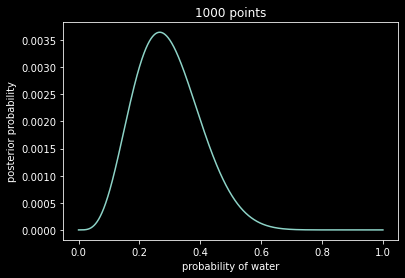

In [3]:
plt.plot(p_grid.numpy(), posterior.numpy(), "-")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("1000 points")
plt.show()

2. Now suppose the data are 4 water and 2 land. Compute the posterior
again, but this time use a prior that is zero below p = 0.5 and a constant
above p = 0.5. This corresponds to prior information that a majority of the
Earth’s surface is water.

Here it is the same calculation, only zeoing the prior for $p<0.5$.

In [4]:
# define grid
p_grid = torch.Tensor(np.linspace(start=0, stop=1, num=1000))

# define prior
prior = torch.Tensor(np.repeat(1, 1000))
prior[:500] = 0

# compute likelihood at each value in grid
likelihood = torch.exp(dist.Binomial(total_count=4+2, probs=p_grid).log_prob(torch.Tensor([4])))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / torch.sum(unstd_posterior)

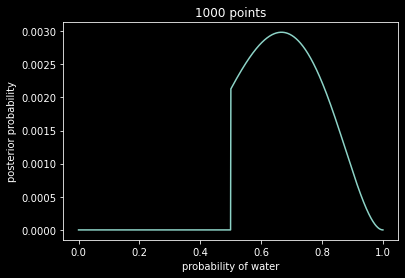

In [5]:
plt.plot(p_grid.numpy(), posterior.numpy(), "-")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("1000 points")
plt.show()

3. For the posterior distribution from 2, compute 89% percentile and HPDI
intervals. Compare the widths of these intervals. Which is wider? Why? If
you had only the information in the interval, what might you misunderstand
about the shape of the posterior distribution?

We are asked to calculate $89%$ confidence intervals in two ways: 1. using equal-sized tails (PI - Percentile interval), 2. The smallest confidence interval that contains $89%$ of the probability mass (HPDI).

The calculation is done numerically. The each of the grid vales is drawn with a probability that is given by the posterior. It is done many times (1e4) with replacement. Then, it is calculated numerically by the functions PI and HPDI with $prob=0.89$. 

In [6]:
samples = np.random.choice(p_grid.numpy(), p=posterior.numpy(), size=10000, replace=True)

In [7]:
(pyro.ops.stats.pi(torch.Tensor(samples), prob=0.89), 
pyro.ops.stats.hpdi(torch.Tensor(samples), prob=0.89) )


(tensor([0.5245, 0.8799]), tensor([0.5005, 0.8408]))

4. OPTIONAL CHALLENGE. Suppose there is bias in sampling so that Land
is more likely than Water to be recorded. Specifically, assume that 1-in-5
(20%) of Water samples are accidentally recorded instead as ”Land”. First,
write a generative simulation of this sampling process. Assuming the true
proportion of Water is 0.70, what proportion does your simulation tend to
produce instead? Second, using a simulated sample of 20 tosses, compute
the unbiased posterior distribution of the true proportion of water.

The unbiased probability of getting $n_W$ and $n_L$ is given by the Binomial distribution with probability $p$:  
$B(n_{trueW}, n=n_{trueL}+n_{trueW}|prob=p)$  
The bias is also given by the Binomial distribution with probability $prob=0.8$:  
$B(n_W, n=n_{trueW}|prob=0.8)$  


a. Simulation of the probability of getting $n_W$ for $p=0.7$ is:

In [48]:
bernuli_trials = 20
N_repitions = 100000
trueW = dist.Binomial(total_count=bernuli_trials, probs=0.7).sample([N_repitions])
obsW = dist.Binomial(total_count=trueW, probs=0.8).sample()
print("trueW", (trueW/20).mean())
print("obsW", (obsW/20).mean())


0.6878606797749979

In [14]:
help(torch.distributions.binomial.Binomial)

Help on class Binomial in module torch.distributions.binomial:

class Binomial(torch.distributions.distribution.Distribution)
 |  Binomial(total_count=1, probs=None, logits=None, validate_args=None)
 |  
 |  Creates a Binomial distribution parameterized by :attr:`total_count` and
 |  either :attr:`probs` or :attr:`logits` (but not both). :attr:`total_count` must be
 |  broadcastable with :attr:`probs`/:attr:`logits`.
 |  
 |  Example::
 |  
 |      >>> m = Binomial(100, torch.tensor([0 , .2, .8, 1]))
 |      >>> x = m.sample()
 |      tensor([   0.,   22.,   71.,  100.])
 |  
 |      >>> m = Binomial(torch.tensor([[5.], [10.]]), torch.tensor([0.5, 0.8]))
 |      >>> x = m.sample()
 |      tensor([[ 4.,  5.],
 |              [ 7.,  6.]])
 |  
 |  Args:
 |      total_count (int or Tensor): number of Bernoulli trials
 |      probs (Tensor): Event probabilities
 |      logits (Tensor): Event log-odds
 |  
 |  Method resolution order:
 |      Binomial
 |      torch.distributions.distributio